# The Best Neighborhood in Pittsburgh

## Description
* Here is an analysis of our methodology for selecting the best neighborhoods in Pittsburgh. We used three metrics: number of incident, number of parks, and number of K-12 registrations. Among these, we considered security as the most crucial factor and assigned a weightage of 40% to it, and 30% to each of the other two factors. We assigned scores to each neighborhood based on its rank in the respective metric and then multiplied it by its corresponding weightage to obtain the overall score for the neighborhood. Finally, we ranked the neighborhoods based on their total scores to identify the top neighborhoods in Pittsburgh.

In [2]:
import pandas as pd
import numpy as np

education = pd.read_csv("neighborhood_iep.csv")
incident_data = pd.read_csv("Incident.csv")
parks = pd.read_csv("parks.csv")

neighborhoods_k12 = pd.DataFrame(columns=['Neighborhood', 'K12 Enrollment'])

for i in range(len(education)):
    neighborhood_str = education.iloc[i]['neighborhoods']
    k12 = education.iloc[i]['total_enrollment_k_12']
    neighborhoods_list = neighborhood_str.split(', ')
    neighborhood = neighborhoods_list[0].strip()
    
    for neighborhood in neighborhoods_list:
        neighborhoods_k12.loc[len(neighborhoods_k12)] = [neighborhood, k12]

safety_weight = 0.4
k12_weight = 0.3
park_weight = 0.3

safety_ranking = incident_data["INCIDENTNEIGHBORHOOD"].value_counts().sort_values(ascending=True)
k12_ranking = neighborhoods_k12.groupby('Neighborhood')['K12 Enrollment'].sum().sort_values(ascending=False)
park_ranking = parks["neighborhood"].value_counts().sort_values(ascending=False)

# the "scores" is a normalized measure of the number of arrests/k12/parks in each neighborhood, which allows for comparison of neighborhoods.
neighborhood_scores = pd.DataFrame(index=safety_ranking.index)
neighborhood_scores["Safety_score"] = 100 * (safety_ranking.max() - safety_ranking) / (safety_ranking.max() - safety_ranking.min())
neighborhood_scores["K12_score"] = 100 * (1 - ((k12_ranking.max() - k12_ranking) / (k12_ranking.max() - k12_ranking.min())))
neighborhood_scores["Park_score"] = 100 * (1 - ((park_ranking.max() - park_ranking) / (park_ranking.max() - park_ranking.min())))
neighborhood_scores["Total_score"] = (neighborhood_scores["Safety_score"] * safety_weight
                                       + neighborhood_scores["K12_score"] * k12_weight
                                       + neighborhood_scores["Park_score"] * park_weight)

best_neighborhoods = neighborhood_scores.sort_values("Total_score", ascending=False)
top5 = best_neighborhoods.iloc[:5]
print(top5)

# Export csv file
best_neighborhoods = best_neighborhoods.reset_index()
best_neighborhoods.columns = ["Neighborhood", "Arrest_score", "K12_score", "Park_score", "Total_score"]
best_neighborhoods.to_csv("best_neighborhoods.csv", index=False)

                     Safety_score  K12_score  Park_score  Total_score
East Liberty            81.100478  50.762712  100.000000    77.669005
Beechview               86.842105  54.322034   63.636364    70.124361
Squirrel Hill South     86.124402  54.406780   45.454545    64.408158
Carrick                 76.076555  93.474576   18.181818    63.927540
Brookline               82.057416  85.000000   18.181818    63.777512


## Map
* The following map shows the distribution of top 5 neighborhoods in Pittsburgh.

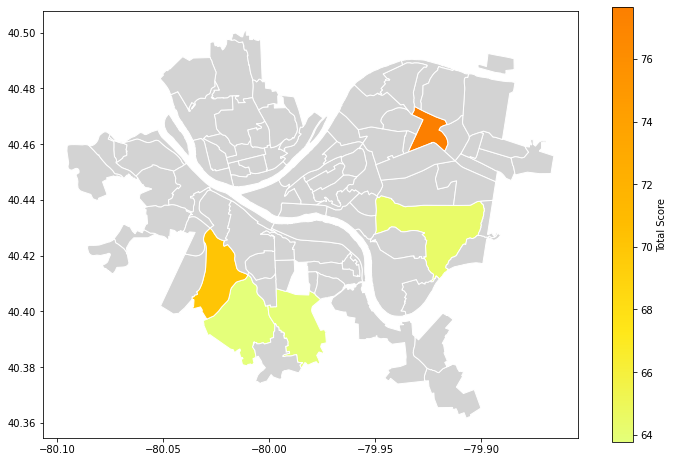

In [12]:
import geopandas

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
# do the merge
best_neighborhood_map = neighborhoods.merge(top5, how='left', left_on='hood', right_index=True)
# look at the head to confirm it merged correctly
best_neighborhood_map[['hood','Total_score','geometry']].head()

best_neighborhood_map.plot(column='Total_score', # set the data to be used for coloring
               cmap='Wistia',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Total Score"}, # label the legend
               figsize=(12, 8),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

## Conclusion
* Based on the total score, we determined that East Liberty is the best neighborhood in Pittsburgh according to our criteria. This is because it has the highest number of parks in Pittsburgh. However, if safety or education level is considered to be more significant, then Beechview and Squirrel Hill South are better options.